# 用fastGB生成天琴双白矮星信号的实例教程

In [1]:
import numpy as np
import sys, os
import time

import matplotlib.pyplot as plt
#import matplotlib as mpl
#import pandas as pd
from scipy.fftpack import fft,rfft

In [2]:
#from LISAhdf5 import LISAhdf5,ParsUnits
#import tdi
#import FastGB as FB    # 导入fastGB
from gwspace import Constants as const

from gwspace import FastGB as FB
# from gwspace import _FastGB as _FB

# fastGB

In [3]:
def GenerateFastGB(p, Tobs, Cadence, oversample, TD = False):   # 默认TD = False，即生成频域信号。如果要生成时域信号那么需要标明TD = True
    #{{{
    ### unfolding the parameters and producing the list of Params
    Amp = p[0]
    f0 = p[1]
    fdot = p[2]
    iota = p[3]
    psi = p[4]
    phi0 = p[5]
    EclLat = p[6]
    EclLon = p[7]

    Tobs = Tobs
    del_t = Cadence
    Ns = len(Amp)    # 源的个数

    prm = []
    for i in range(Ns):
        tmp = np.array([f0[i], fdot[i], EclLat[i], EclLon[i], Amp[i], iota[i], psi[i], phi0[i]])
        prm.append(tmp)
    fastB = FB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic", detector="TianQin")

    if TD:
        Xt, Yt, Zt = fastB.TDI(T=Tobs,dt=del_t,simulator='synthlisa',table=prm,
        algorithm='Michele',oversample=oversample)
        tm = np.arange(len(Xt))*del_t

        return (tm, Xt, Yt, Zt)

    else:
        Xf, Yf, Zf = fastB.fourier(T=Tobs,dt=del_t,simulator='synthlisa',
        table=prm,algorithm='Michele',oversample=oversample)
        return(Xf.f,Xf[:],Yf[:],Zf[:])


In [4]:
f0=[0.001]
fd=[1.4485090098056043e-18]
beta=[1.2]  #ecliptic latitude [rad]
Lambda=[0.4]  #ecliptic longitude [rad]
Amp=[4.951070670976774e-25]
iota=[0.3]
psi=[0.2]
phi0=[0.0]

Tobs = 62914560.0
Cadence = 15.0

paras = [Amp, f0, fd, iota, psi, phi0, beta, Lambda]

# 调用函数生成频域信号（如果需要时域，则在括号里再加一个TD = True即可）
J0806_FD_highos = GenerateFastGB(paras, Tobs, Cadence, 32768)

# 处理得到的数据，方便画图
J0806_FD_highos = np.array(J0806_FD_highos).T
J0806_FD_highos[:,1:] = J0806_FD_highos[:,1:]*2

import pandas as pd
df_J0806_highos = pd.DataFrame(np.abs(J0806_FD_highos),columns=['f','TDI X (FD)', 'TDI Y (FD)', 'TDI Z (FD)'])


1 finished, 3 s elapsed (0/s)


# 卢杨编写的解析波形

In [5]:
from numpy import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import integrate
from scipy.fftpack import fft,rfft

def sinc(parameter):
    sinc = np.sin(parameter)/parameter
    return sinc

def h_X(t,f,beta,Lambda,f_drift, Amp, iota, psi, phi0):

    beta = beta      # 黄纬
    Lambda =Lambda   # 黄经
    f_drift =f_drift
    t=t
    T = max(t)

    # 以下计算q向量要用到：
    Lc = 0.5777499579392          # L/c 自然单位制
    e=0.0167       #地球轨道的偏心率
    yearspersecond = 3.1709791983764586e-8
    alpha = 2*np.pi*t*yearspersecond + (2.102137+np.pi-np.pi/4.0)
    period = 3.65*24*60*60
    isc = 1.652897
    bsc = 2.102137
    kapa = 20/180 * np.pi
    beta_1 = 2.0*np.pi*(1-1)/3.0 + kapa;
    beta_2 = 2.0*np.pi*(2-1)/3.0 + kapa;
    beta_3 = 2.0*np.pi*(3-1)/3.0 + kapa;
    gamma_1 = 2.0*np.pi*(t/period) + beta_1
    gamma_2 = 2.0*np.pi*(t/period) + beta_2
    gamma_3 = 2.0*np.pi*(t/period) + beta_3
    
    
    # 以下计算相位phi_t要用到：
    eta_0 =(2.102137+np.pi-np.pi/4.0)     # η0 是t=0时航天器在环太阳轨道上的位置
    omega = 2*np.pi*f                     # 角频率 2Πf
    omegaDerivative = 2*np.pi*f_drift     # omega_dot
    yearspersecond = 3.1709791983764586e-8
    OMRGA = 2*np.pi*yearspersecond
    R = 499.004                           # 1AU = 1.5e11 m /c
    
    # 计算探测器通道响应要用到：
    x = Lc * omega
    
    
    ######################### 航天器相对于guiding-center的位置向量q，忽略偏心率项 ####################################
    
    # x坐标，指标中的前一个数字123分别表示3个航天器
    q_vectors_11 = 1.0/2*(np.cos(2*(alpha))-3.0)*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.cos(bsc)*np.cos(gamma_1) - np.sin(bsc)*np.sin(gamma_1))
    q_vectors_21 = 1.0/2*(np.cos(2*(alpha))-3.0)*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.cos(bsc)*np.cos(gamma_2) - np.sin(bsc)*np.sin(gamma_2))
    q_vectors_31 = 1.0/2*(np.cos(2*(alpha))-3.0)*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.cos(bsc)*np.cos(gamma_3) - np.sin(bsc)*np.sin(gamma_3))
    
    # y坐标
    q_vectors_12 = 1.0/2*(np.sin(2*(alpha)))*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.sin(bsc)*np.cos(gamma_1) + np.cos(bsc)*np.sin(gamma_1))
    q_vectors_22 = 1.0/2*(np.sin(2*(alpha)))*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.sin(bsc)*np.cos(gamma_2) + np.cos(bsc)*np.sin(gamma_2))
    q_vectors_32 = 1.0/2*(np.sin(2*(alpha)))*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.sin(bsc)*np.cos(gamma_3) + np.cos(bsc)*np.sin(gamma_3))
      
    # z坐标
    q_vectors_13 = -1.0/3**0.5*np.sin(isc)*np.cos(gamma_1)
    q_vectors_23 = -1.0/3**0.5*np.sin(isc)*np.cos(gamma_2)
    q_vectors_33 = -1.0/3**0.5*np.sin(isc)*np.cos(gamma_3)
    
    ######################################### 臂长向量n ########################################

    # 向量n1 = q2-q3，三维，臂长1对应的向量
    n_vectors_11 = q_vectors_21 - q_vectors_31
    n_vectors_12 = q_vectors_22 - q_vectors_32
    n_vectors_13 = q_vectors_23 - q_vectors_33
    
    # 向量n2 = q3-q1
    n_vectors_21 = q_vectors_31 - q_vectors_11
    n_vectors_22 = q_vectors_32 - q_vectors_12
    n_vectors_23 = q_vectors_33 - q_vectors_13
    
    # 向量n3 = q1-q2
    n_vectors_31 = q_vectors_11 - q_vectors_21
    n_vectors_32 = q_vectors_12 - q_vectors_22
    n_vectors_33 = q_vectors_13 - q_vectors_23

    
    ##############################    相位函数，包含多普勒调制   ##############################

    phi_t = omega*t + 0.5*omegaDerivative*t**2 + phi0 +(omega + omegaDerivative*t)*R * np.cos(beta) * np.cos(OMRGA*t + eta_0 - Lambda)


    ################# polarization basis in the solar system barycenter frame ##################
    u_vectors_1 = np.sin(beta)*np.cos(Lambda)  # dk/dβ
    u_vectors_2 = np.sin(Lambda)*np.sin(beta)
    u_vectors_3 = -np.cos(beta)

    v_vectors_1 = np.sin(Lambda)
    v_vectors_2 = -np.cos(Lambda)
    v_vectors_3 = 0.0

    
	################# direction of the wave propagation. 波矢 ########################
    k_vectors_1 = -np.cos(Lambda)*np.cos(beta)
    k_vectors_2 = -np.cos(beta)*np.sin(Lambda)
    k_vectors_3 = -np.sin(beta)


    # u标量
    u_scalar_1 = -0.5*((n_vectors_11*u_vectors_1 + n_vectors_12*u_vectors_2 +n_vectors_13*u_vectors_3)**2-\
                            (n_vectors_11*v_vectors_1 + n_vectors_12*v_vectors_2 +n_vectors_13*v_vectors_3)**2)

    u_scalar_2 = -0.5*((n_vectors_21*u_vectors_1 + n_vectors_22*u_vectors_2 +n_vectors_23*u_vectors_3)**2-\
                            (n_vectors_21*v_vectors_1 + n_vectors_22*v_vectors_2 +n_vectors_23*v_vectors_3)**2)

    u_scalar_3 = -0.5*((n_vectors_31*u_vectors_1 + n_vectors_32*u_vectors_2 +n_vectors_33*u_vectors_3)**2-\
                            (n_vectors_31*v_vectors_1 + n_vectors_32*v_vectors_2 +n_vectors_33*v_vectors_3)**2)

    # v标量
    v_scalar_1 = ((n_vectors_11*u_vectors_1 + n_vectors_12*u_vectors_2 +n_vectors_13*u_vectors_3)*\
                       (n_vectors_11*v_vectors_1 + n_vectors_12*v_vectors_2 +n_vectors_13*v_vectors_3))

    v_scalar_2 = ((n_vectors_21*u_vectors_1 + n_vectors_22*u_vectors_2 +n_vectors_23*u_vectors_3)*\
                       (n_vectors_21*v_vectors_1 + n_vectors_22*v_vectors_2 +n_vectors_23*v_vectors_3))

    v_scalar_3 = ((n_vectors_31*u_vectors_1 + n_vectors_32*u_vectors_2 +n_vectors_33*u_vectors_3)*\
                       (n_vectors_31*v_vectors_1 + n_vectors_32*v_vectors_2 +n_vectors_33*v_vectors_3))
    
    
    ####################################### 探测器X通道响应 #######################################################
    
    X_1 = u_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -u_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    X_2 = v_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -v_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    X_3 = u_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -u_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    X_4 = v_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -v_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    # 响应后的信号（只包含内秉参数）
    h1 =2*omega*Lc*np.sin(omega*Lc)*X_1
    h2 =2*omega*Lc*np.sin(omega*Lc)*X_2
    h3 =2*omega*Lc*np.sin(omega*Lc)*X_3
    h4 =2*omega*Lc*np.sin(omega*Lc)*X_4
    h=[h1,h2,h3,h4]
    
    # 外秉部分
    h_zero =Amp
    h_plus = h_zero*(1 + (np.cos(iota))**2)
    h_cross = 2*h_zero*np.cos(iota)
    
    a_1 = h_plus * np.cos(phi0) * np.cos(2*psi) - h_cross*np.sin(phi0)*np.sin(2*psi)
    a_2 = h_plus * np.cos(phi0) * np.sin(2*psi) + h_cross*np.sin(phi0)*np.cos(2*psi)
    a_3 = -h_plus * np.sin(phi0) * np.cos(2*psi) - h_cross*np.cos(phi0)*np.sin(2*psi)
    a_4 = -h_plus * np.sin(phi0) * np.sin(2*psi) + h_cross*np.cos(phi0)*np.cos(2*psi)
    
    TDIX_t=h1*a_1+h2*a_2+h3*a_3+h4*a_4
    
    return TDIX_t



In [6]:
f0=[0.001]
fd=[1.4485090098056043e-18]
beta=[1.2]  #ecliptic latitude [rad]
Lambda=[0.4]  #ecliptic longitude [rad]
Amp=[4.951070670976774e-25]
iota=[0.3]
psi=[0.2]
phi0=[0.0]


t=np.arange(0, 62914560, 15)  # 同样取2年观测时长，15s采样间隔

Nsignal = len(f0)   # 信号数量

X = np.zeros((Nsignal,len(t)))
X_t_total = np.zeros(len(t))
for i in range(Nsignal):
    X[i,:]=h_X(t,f0[i],beta[i],Lambda[i],fd[i], Amp[i], iota[i], psi[i], phi0[i])
    X_t_total=X_t_total+X[i,:]

# fft
fs = 1/15
X_f = np.abs(np.fft.rfft(X_t_total))/len(X_t_total)*2
xf = np.linspace(0,fs/2,len(X_f))

# GCBwaveform

In [7]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from gwspace.Waveform import waveforms
from gwspace.response import get_td_response
from gwspace.Orbit import TianQinOrbit, detectors
from gwspace.Constants import DAY, YRSID_SI, MSUN_SI, MPC_SI
from gwspace.TDI import XYZ_TD, TDI_XYZ2AET


def Generate_TD_Data(pars, detector='TQ', show_yslr=False):
    print("This is TD response generation code")
    Tobs = 62914560 # pars['T_obs']*10  # YRSID_SI / 4
    delta_f = 1/Tobs
    delta_T = 15
    f_max = 1/(2*delta_T)

    # tf = np.arange(0,Tobs, delta_T)
    # be careful, the arange method will lose the largest value
    tf = np.linspace(0, Tobs, int(Tobs/delta_T))

    print(f"Testing of {pars['type']} waveform")

    #help(WF.GCBWaveform)
    WFs = waveforms[pars['type']]
    wf = WFs(**pars)

    orbits = detectors[detector]
    det = orbits(tf)
    
    st = time.time()
    yslr = get_td_response(wf, det, tf)
    ed = time.time()

    print("Time cost is %f s for %d points" % (ed-st, tf.shape[0]))

    if show_yslr:
        tags = [(1, 2), (2, 1), (2, 3), (3, 2), (3, 1), (1, 3)]

        for i, tag in enumerate(tags):
            plt.figure()
            for j in range(4):
                plt.subplot(4, 1, j+1)
                plt.plot(tf, yslr[tag][f"%sL" % j])
                plt.title(f"y_{tag} [%s]L" % j)

    st = time.time()
    X, Y, Z = XYZ_TD(yslr)
    A, E, T = TDI_XYZ2AET(X, Y, Z)
    ed = time.time()

    np.save(detector+pars["type"]+"_X_td.npy", np.array([tf, X]))

    print("Time cost for cal XYZ and AET with yslr is ", ed-st)
    return X,Y,Z,A,E,T

    '''

    plt.figure()
    for i, dd in enumerate(["X", "Y", "Z", "A", "E", "T"]):
        dat = eval(dd)
        plt.subplot(2, 3, i+1)
        plt.plot(tf[:-5], dat[:-5], label=dd)

        plt.xlabel("Time")
        plt.ylabel(dd)

        plt.legend(loc="best")

    plt.show()
    '''


def Generate_FD_Data(pars, show_yslr=False):
    print("This is a test for frequency domain response")

    print("Testing of BHB waveform")

    TQ = INITianQin()
    fd = FDResponse(pars, TQ)

    NF = 10240
    freq = 10**np.linspace(-4, 0, NF)

    BHBwf = WaveForm(pars)

    amp, phase, tf, tfp = BHBwf.get_amp_phase(freq, )

    st = time.time()

    Gslr, zeta = fd.EvaluateGslr(tf[(2, 2)], freq)  # fd.Evaluate_yslr(freq)
    yslr = fd.Evaluate_yslr(freq)  # fd.Evaluate_yslr(freq)
    ed = time.time()

    print(f"time cost for the fd response is {ed-st} s")

    if show_yslr:
        mode = [(2, 2)]
        ln = [(1, 2), (2, 3), (3, 1), (1, 3), (3, 2), (2, 1)]

        for ll in ln:
            plt.figure()
            gg = Gslr[ll]
            yy = yslr[mode[0]][ll]
            plt.plot(freq, gg, '-r')
            plt.plot(freq, yy, '--b')
            plt.title(ll)

            plt.xscale('log')

    X, Y, Z = XYZ_FD(yslr[(2, 2)], freq, LT=fd.LT)
    A, E, T = AET_FD(yslr[(2, 2)], freq, fd.LT)

    plt.figure()
    plt.loglog(freq, np.abs(X), '-r', label='X')
    plt.loglog(freq, np.abs(Y), '--g', label='Y')
    plt.loglog(freq, np.abs(Z), ':b', label='Z')

    plt.xlabel('f')
    plt.ylabel('X,Y,Z')
    plt.legend(loc='best')

    plt.figure()
    plt.loglog(freq, np.abs(A), '-r', label='A')
    plt.loglog(freq, np.abs(E), '--g', label='E')
    plt.loglog(freq, np.abs(T), ':b', label='T')

    plt.xlabel('f')
    plt.ylabel('A,E,T')
    plt.legend(loc='best')

    plt.show()


if __name__ == "__main__":
    GCBpars = {"type": "gcb",
               "mass1": 0.5,
               "mass2": 0.5,
               "DL": 0.3,
               "phi0": 0.0,
               "f0": 0.001,
               "psi": 0.2,
               "iota": 0.3,
               "Lambda": 0.4,
               "Beta": 1.2,
               "T_obs": 62914560,
               "fddot": 0,
               }

    EMRIpars = {"type": "emri",
                'M': 1e6,
                'a': 0.1,
                'mu': 1e1,
                'p0': 12.0,
                'e0': 0.2,
                'x0': 1.0,
                'qK': 0.2,
                'phiK': 0.2,
                'qS': 0.3,
                'phiS': 0.3,
                'dist': 1.0,
                'Phi_phi0': 1.0,
                'Phi_theta0': 2.0,
                'Phi_r0': 3.0,
                'psi': 0.4,
                'iota': 0.2,
                }

    BHBpars = {"type": "BHB",
               "m1": 3.5e6,
               "m2": 2.1e5,
               "chi1": 0.2,
               "chi2": 0.1,
               "DL": 1e3,
               "phic": 0.0,
               "MfRef_in": 0,
               "psi": 0.2,
               "iota": 0.3,
               "lambda": 0.4,
               "beta": 1.2,
               "tc": 0,
               }
    eccpara = {"type": 'bhb_EccFD',
            'delta_f': 0.0001,
            'f_final': 1,
            'f_lower': 0.01,
            'mass1': 10 * MSUN_SI,
            'mass2': 10 * MSUN_SI,
            'inclination': 0.23,
            'eccentricity': 0.4,
            'long_asc_nodes': 0.23,
            'coa_phase': 0,
            'distance': 100 * MPC_SI,
            'obs_time': 365*24*3600}
    
    XTD,YTD,ZTD,ATD,ETD,GTD = Generate_TD_Data(GCBpars)
    #Generate_TD_Data(EMRIpars)#, show_yslr=True)
    #Generate_FD_Data(eccpara)


This is TD response generation code
Testing of gcb waveform
Time cost is 20.689968 s for 4194304 points
Time cost for cal XYZ and AET with yslr is  0.20791125297546387


In [8]:
fs = 1/15
XFD = np.abs(np.fft.rfft(XTD))/len(XTD)*2
xf = np.linspace(0,fs/2,len(XFD))

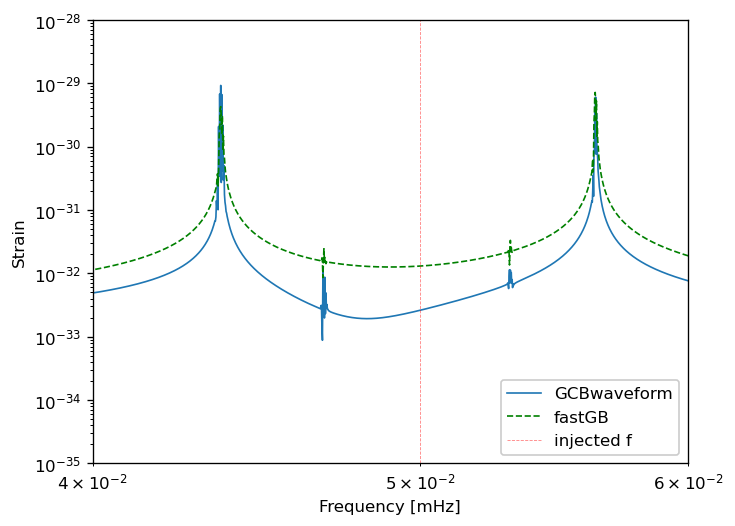

In [21]:
plt.figure(dpi=120)
plt.loglog(xf*1e3-0.95, XFD, linewidth=1, label='GCBwaveform')
#plt.loglog(xf*1e3-0.95, X_f.real, linewidth=1,color= 'orange', label='analytic waveform by LuYang')
plt.loglog(J0806_FD_highos[:,0]*1e3-0.95 , abs(J0806_FD_highos[:,1]), linestyle='--', linewidth=1,color= 'g', label='fastGB')


plt.axvline(f0[0]*1e3-0.95 ,color='r' ,linestyle='--', linewidth=0.5 , alpha = 0.5 ,label='injected f')

plt.xlabel("Frequency [mHz]")
plt.ylabel("Strain")
plt.xlim(f0[0]*1e3-1e-2-0.95, f0[0]*1e3+1e-2-0.95)
# plt.xlim(9.928e-4, 9.948e-4)    # 左半边
# plt.xlim(10.055e-4, 10.075e-4)  # 右半边
plt.ylim(1e-35,1e-28)
plt.legend(loc=4, framealpha=1)
plt.show()

/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


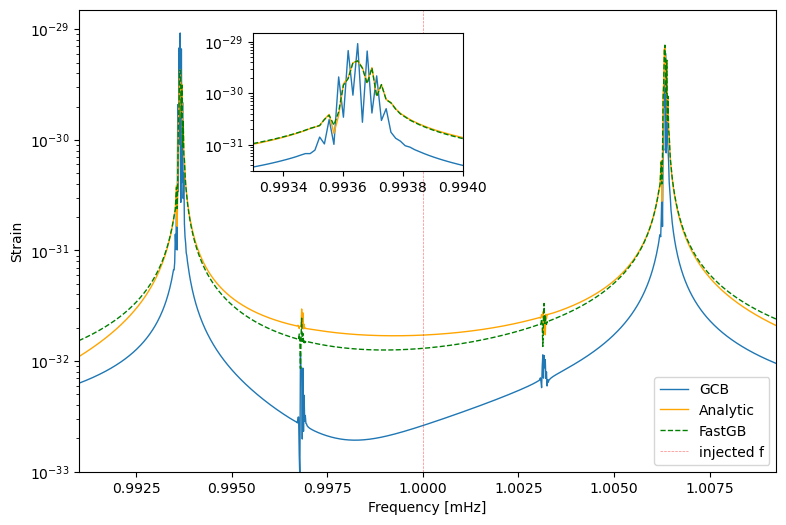

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(xf*1e3, XFD, linewidth=1, label='GCB')
ax.plot(xf*1e3, X_f, linewidth=1,color= 'orange', label='Analytic')
ax.plot(J0806_FD_highos[:,0]*1e3 , np.abs(J0806_FD_highos[:,1]), linestyle='--', linewidth=1,color= 'g', label='FastGB')

ax.axvline(f0[0]*1e3 ,color='r' ,linestyle='--', linewidth=0.5 , alpha = 0.5 ,label='injected f')

ax.set_ylim(1e-33,1.5e-29)
ax.set_xlim(f0[0]*1e3-0.9e-2, f0[0]*1e3+0.925e-2)
#ax.set_xscale('log')
ax.set_yscale('log')

axins = ax.inset_axes((0.25, 0.65, 0.3, 0.3))
axins.plot(xf*1e3, XFD, linewidth=1, label='GCBwaveform')
axins.plot(xf*1e3, X_f, linewidth=1,color= 'orange', label='analytic waveform by LuYang')
axins.plot(J0806_FD_highos[:,0]*1e3 , np.abs(J0806_FD_highos[:,1]), linestyle='--', linewidth=1,color= 'g', label='fastGB')
axins.set_ylim(3e-32,1.5e-29)
axins.set_xlim(0.9933,0.994)
#ax.set_xscale('log')
axins.set_yscale('log')

#axins = ax.inset_axes((0.1, 0.5, 0.1, 0.1))
ax.set_xlabel("Frequency [mHz]")
ax.set_ylabel("Strain")

plt.legend(loc=4)

plt.savefig("../../../TQ-SDS/figs/GCB_fd.pdf", dpi=360)